In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wmfdata as wmf

from wmfdata.utils import (
    pct_str,
    pd_display_all
)

In [30]:
wmf.charting.set_mpl_style()

## Data notes
* The experiment was released to the KaiOS store on 8 April 2021, in version 1.6.0 of the app. On 5 May, we [fixed](https://www.mediawiki.org/w/index.php?title=Wikipedia_for_KaiOS/engagement1&diff=4563366&oldid=4520262) a vandalization of our config that prevent the recommendations from being shown.
* After the scheduled publication of recommendations on 2 June at 03:00 UTC, an infrastructure issue prevented new recommendations from being published (although the existing recommendations continued to be served to app users). The issue was fixed and updated set of recommendations were published on 4 June at 23:00 UTC, followed by scheduled updates as normal.
* The drop in events starting on 29 August is expected, since that's when KaiOS stopped running ads for our app in their ad network.
* There was a significant break in the trending articles job, from 6 October through 20 October (the trending articles from 5 October continued to be displayed during this period).
* We [stopped the experiment](https://www.mediawiki.org/w/index.php?title=Wikipedia_for_KaiOS/engagement1&diff=5006968&oldid=4746787) after 7 January 2022.

## Initial data exploration

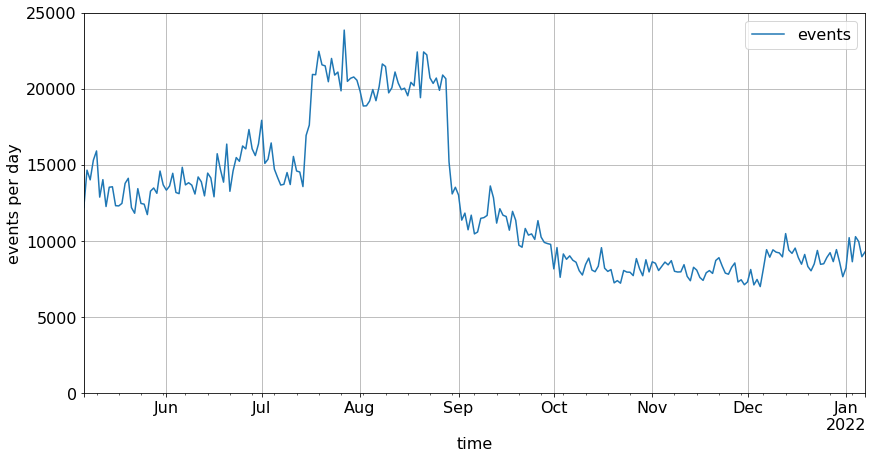

In [6]:
experiment_events = wmf.presto.run("""
    SELECT
        DATE(server_dt) AS time,
        COUNT(*) AS events
    FROM nshahquinn.kaios_experiment_event_combined
    GROUP BY DATE(server_dt)
    ORDER BY time
""").set_index("time")

experiment_events.plot(
    ylim=(0, 25_000),
    ylabel="events per day"
);

In [7]:
wmf.presto.run("""
SELECT
    country IN ('NG', 'PK', 'TZ', 'UG') as focus_country,
    COUNT(*) AS events,
    COUNT(DISTINCT user_id) AS users
FROM nshahquinn.kaios_experiment_event_combined
GROUP BY country IN ('NG', 'PK', 'TZ', 'UG')
""")

,focus_country,events,users
0,True,1616125,116542
1,False,1508513,51450


In [8]:
wmf.presto.run("""
SELECT
    app_version,
    COUNT(*) AS events
FROM nshahquinn.kaios_experiment_event_combined
GROUP BY app_version
""")

,app_version,events
0,1.7.0.0,224
1,1.8.1.0,162
2,0.0.0,555
3,1.6.0,3123697


In [9]:
user_agg = wmf.presto.run("""
SELECT
    user_id,
    ARRAY_JOIN(SET_AGG(country), '-') AS country,
    ARRAY_JOIN(SET_AGG(experiment_group), '-') AS experiment_group,
    ARRAY_JOIN(SET_AGG(wiki), '-') AS wiki
FROM nshahquinn.kaios_experiment_event_combined
GROUP BY user_id
""")

In [10]:
user_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167888 entries, 0 to 167887
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           167888 non-null  object
 1   country           167888 non-null  object
 2   experiment_group  167888 non-null  object
 3   wiki              167888 non-null  object
dtypes: object(4)
memory usage: 5.1+ MB


In [11]:
focus_users_all_wikis = (
    user_agg
    .query(
        "country in ('NG', 'PK', 'TZ', 'UG') "
        "and experiment_group in ('control', 'trending-articles')"
    )
)

In [12]:
focus_users_all_wikis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116435 entries, 0 to 167887
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           116435 non-null  object
 1   country           116435 non-null  object
 2   experiment_group  116435 non-null  object
 3   wiki              116435 non-null  object
dtypes: object(4)
memory usage: 4.4+ MB


In [13]:
(
    focus_users_all_wikis
    .groupby('wiki')
    .size()
    .sort_values(ascending=False)
    .head(20)
)

wiki
                 54550
enwiki           53888
enwiki-           2186
swwiki             702
enwiki-swwiki      521
swwiki-enwiki      519
enwiki-dewiki      399
urwiki             323
enwiki-urwiki      301
urwiki-enwiki      234
enwiki-frwiki      154
frwiki             138
enwiki-eswiki      136
enwiki-nlwiki      123
nlwiki-enwiki      120
nlwiki             114
enwiki-itwiki      102
enwiki-afwiki       84
dewiki-enwiki       74
swwiki-             73
dtype: int64

Let's collect the user-level data, removing any users from outside the focus countries or who switched countries or groups.

In [21]:
user = wmf.presto.run(f"""
WITH pageview AS (
    SELECT
        pageview_id,
        session_id,
        user_id,
        MIN(server_dt) AS start_time,
        MAX(
            -- Convert milliseconds to minutes
            CAST(page_visible_time AS REAL) / 1000 / 60
        ) AS page_viewing_min,
        ARRAY_JOIN(SET_AGG(country), '-') AS country,
        ARRAY_JOIN(SET_AGG(experiment_group), '-') AS experiment_group,
        ARRAY_JOIN(SET_AGG(wiki), '-') AS wiki
    FROM nshahquinn.kaios_experiment_event_combined
    WHERE
        app_version = '1.6.0'
    GROUP BY
        pageview_id,
        session_id,
        user_id
), session AS (
    SELECT
        session_id,
        user_id,
        MIN(start_time) AS start_time,
        SUM(page_viewing_min) AS page_viewing_min,
        ARRAY_JOIN(SET_AGG(country), '-') AS country,
        ARRAY_JOIN(SET_AGG(experiment_group), '-') AS experiment_group,
        ARRAY_JOIN(SET_AGG(wiki), '-') AS wiki
    FROM pageview
    GROUP BY
        user_id,
        session_id
), user_experiment_entry AS (
    SELECT
        user_id,
        MIN(server_dt) AS experiment_entry
    FROM nshahquinn.kaios_experiment_event_combined
    WHERE app_version = '1.6.0'
    GROUP BY user_id
), user AS (
    SELECT
        user_id,
        CAST(DATE_DIFF('second', MIN(start_time), TIMESTAMP '2022-01-08') AS REAL)
            / 60 / 60 / 24 AS days_in_experiment,
        MIN(experiment_entry) AS experiment_entry,
        COUNT(1) AS sessions,
        AVG(page_viewing_min) AS mean_session_min,
        MAX(start_time BETWEEN 
            DATE_ADD('week', 1, experiment_entry)
            AND DATE_ADD('week', 2, experiment_entry)
        ) AS second_week_retained,
        ARRAY_JOIN(SET_AGG(country), '-') AS country,
        ARRAY_JOIN(SET_AGG(experiment_group), '-') AS experiment_group,
        ARRAY_JOIN(SET_AGG(wiki), '-') AS wiki
    FROM session
    LEFT JOIN user_experiment_entry
    USING (user_id)
    GROUP BY user_id
)
SELECT
    user_id,
    experiment_entry,
    days_in_experiment,
    sessions,
    mean_session_min,
    second_week_retained,
    country,
    wiki,
    experiment_group
FROM user
WHERE
    country IN ('NG', 'PK', 'TZ', 'UG')
    AND experiment_group IN ('control', 'trending-articles')
""").assign(
    experiment_entry=lambda df: pd.to_datetime(df["experiment_entry"]),
    country=lambda df: df["country"].astype("category"),
    experiment_group=lambda df: df["experiment_group"].astype("category"),
    wiki=lambda df: df["wiki"].astype("category")
)

In [22]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116435 entries, 0 to 116434
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   user_id               116435 non-null  object        
 1   experiment_entry      116435 non-null  datetime64[ns]
 2   days_in_experiment    116435 non-null  float64       
 3   sessions              116435 non-null  int64         
 4   mean_session_min      116435 non-null  float64       
 5   second_week_retained  116435 non-null  bool          
 6   country               116435 non-null  category      
 7   wiki                  116435 non-null  category      
 8   experiment_group      116435 non-null  category      
dtypes: bool(1), category(3), datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 5.0+ MB


# Data exploration

## Users by countries and experiment groups

In [23]:
pd.pivot_table(
    user,
    # The column used for `values` means nothing since we use `len` as the `aggfunc`.
    values="user_id",
    index="country",
    columns="experiment_group",
    aggfunc=len,
    margins=True
)

experiment_group,control,trending-articles,All
country,,,
NG,7799,7756,15555
PK,25102,24838,49940
TZ,18148,18179,36327
UG,7315,7298,14613
All,58364,58071,116435


## Session duration

In [24]:
user["mean_session_min"].describe()

count    116435.000000
mean         10.224206
std        1002.874318
min        -533.543760
25%           0.401343
50%           1.136550
75%           2.581163
max      252486.750000
Name: mean_session_min, dtype: float64

In [25]:
with pd.option_context("display.min_rows", 30):
    display(user["mean_session_min"].sort_values(ascending=False))

64306     252486.750000
30836     110552.320000
69199     101221.140000
91863      89552.820000
4611       89305.610000
33498      88719.090000
13684      49893.125000
40124      39641.605000
38597      39428.207000
45700      32997.098000
33114      12894.256000
15598      12634.044000
36769        396.418600
73755        173.118800
32562        123.104260
              ...      
19458          0.002267
81410          0.002267
105843         0.002250
90172          0.002117
7746           0.002067
38595          0.002067
105429         0.002050
67800          0.001900
104584         0.001167
29092          0.001117
4431           0.000950
53725          0.000883
31140         -0.015567
90632         -0.748583
8313        -533.543760
Name: mean_session_min, Length: 116435, dtype: float64

Some users have pathological session lengths. Let's remove them.

In [26]:
user = user.query("mean_session_min >= 0 and mean_session_min < 600")

In [27]:
user["mean_session_min"].describe()

count    116420.000000
mean          2.333480
std           4.275131
min           0.000883
25%           0.401332
50%           1.136465
75%           2.580542
max         396.418600
Name: mean_session_min, dtype: float64

In [28]:
# Proportion of users with mean session length of 10 minutes or more
print(pct_str(user["mean_session_min"][lambda x: x >= 10].pipe(len) / len(user)))

3.7%


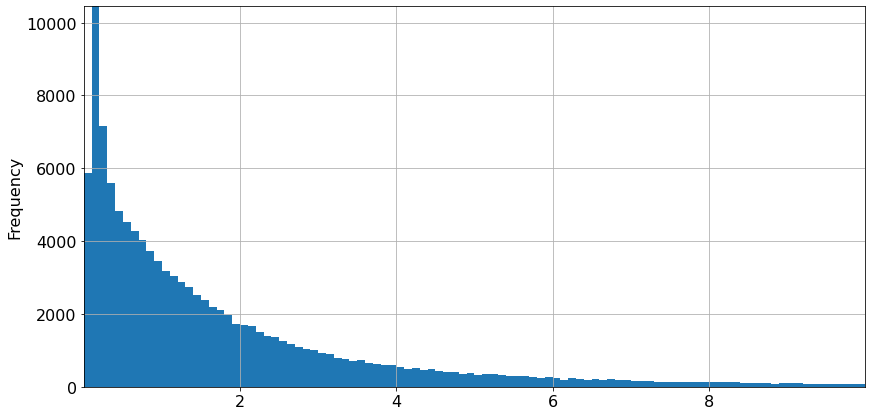

In [31]:
user["mean_session_min"][lambda x: x < 10].plot(kind='hist', bins=100);

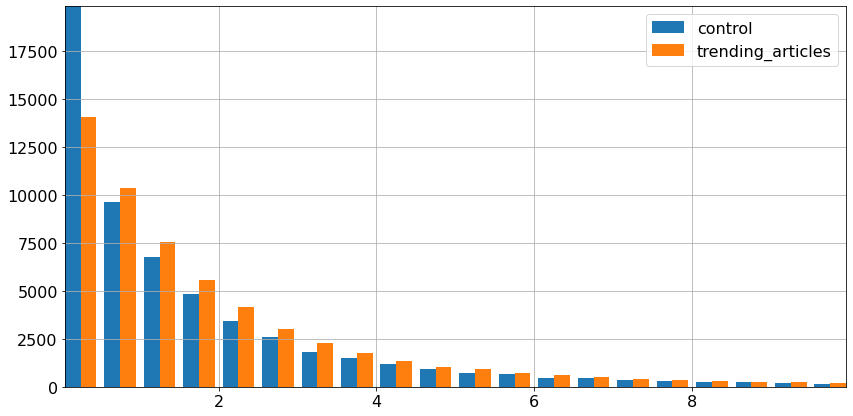

In [32]:
control_session_lengths = user.query("experiment_group == 'control'")["mean_session_min"][lambda x: x <= 10]
trending_articles_session_lengths = user.query("experiment_group == 'trending-articles'")["mean_session_min"][lambda x: x <= 10]

plt.hist([
    control_session_lengths, trending_articles_session_lengths], bins=20, label=["control", "trending_articles"])
plt.legend();

## Session count

In [33]:
user["sessions"].describe()

count    116420.000000
mean          2.148677
std           3.837352
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         321.000000
Name: sessions, dtype: float64

In [34]:
# Proportion of users with ten sessions or more
print(pct_str(user["sessions"][lambda x: x >= 10].pipe(len) / len(user)))

1.5%


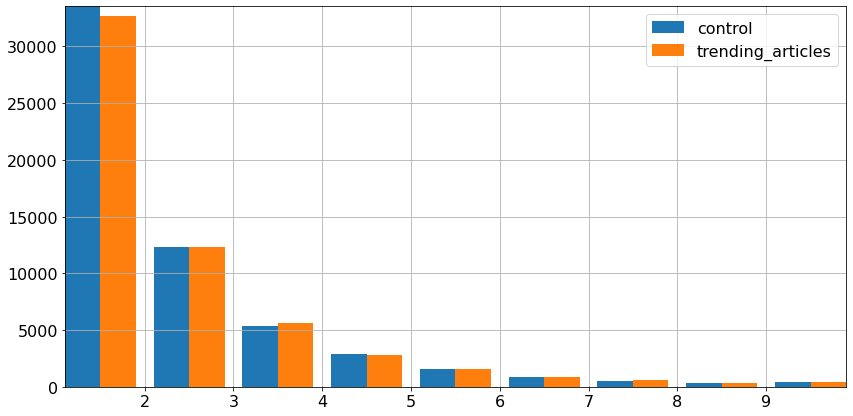

In [35]:
control_session_counts = user.query("experiment_group == 'control'")["sessions"][lambda x: x <= 10]
trending_articles_session_counts = user.query("experiment_group == 'trending-articles'")["sessions"][lambda x: x <= 10]

plt.hist([control_session_counts, trending_articles_session_counts], bins=9, label=["control", "trending_articles"])
plt.legend();

In [36]:
user["experiment_entry"].describe(datetime_is_numeric=True)

count                           116420
mean     2021-07-22 03:26:13.182311424
min         2021-05-06 00:00:00.350000
25%      2021-06-09 18:50:36.096999936
50%      2021-07-14 10:40:46.792499968
75%      2021-08-15 21:59:19.402749952
max         2022-01-07 23:49:30.246000
Name: experiment_entry, dtype: object

In [37]:
user["days_in_experiment"].describe()

count    116420.000000
mean        169.856786
std          56.684986
min           0.007280
25%         145.083792
50%         177.555000
75%         212.214860
max         247.000000
Name: days_in_experiment, dtype: float64

## Correlations

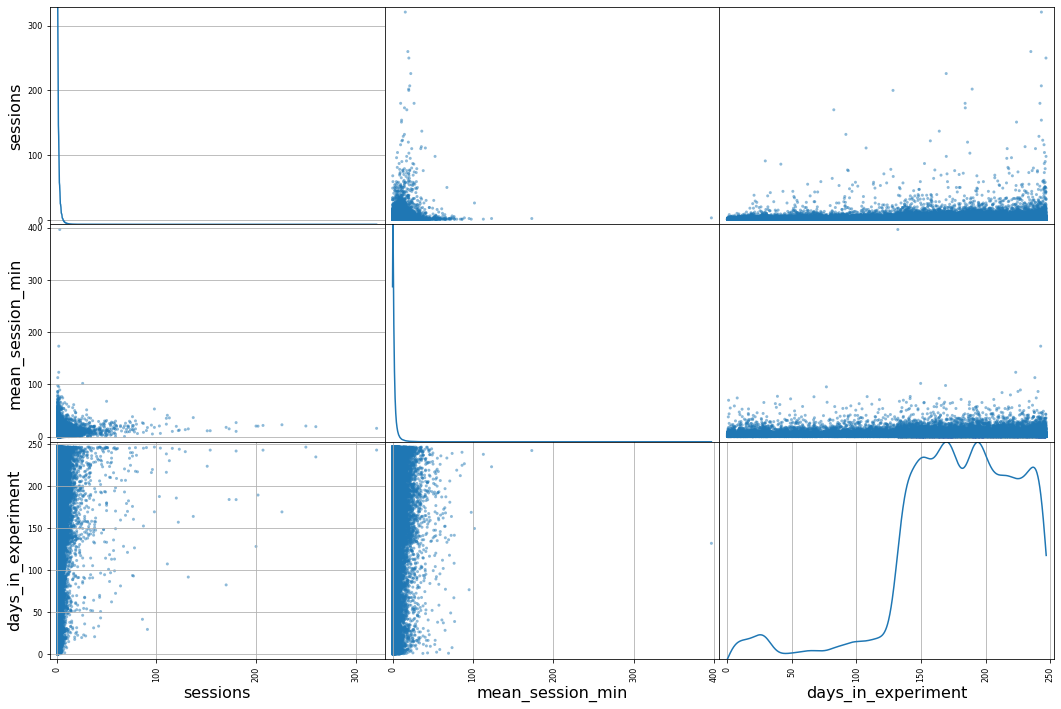

In [38]:
pd.plotting.scatter_matrix(
    user[["sessions", "mean_session_min", "days_in_experiment"]],
    diagonal="kde",
    figsize=(18, 12)
);

In [39]:
user.corr()

,days_in_experiment,sessions,mean_session_min,second_week_retained
days_in_experiment,1.000000,0.039247,-0.036421,0.005573
sessions,0.039247,1.000000,0.201070,0.304919
mean_session_min,-0.036421,0.201070,1.000000,0.095952
second_week_retained,0.005573,0.304919,0.095952,1.000000


In [40]:
user.to_parquet('data/2022-03-07_experiment_user.parquet')